In [2]:


import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from deepxde import utils
import deepxde as dde
from deepxde.backend import tf
from deepxde.nn.tensorflow.fnn import FNN
#dde.backend.set_default_backend("tensorflow")


In [3]:
filebase='/scratch/bbpq/qibang/repository/Adap_data_driven_possion/saved_model/AllData/'
if not os.path.exists(filebase):
    os.makedirs(filebase)



In [4]:

Nx = 128
Ny = 128
m = Nx * Ny
###  N number of samples 1000
###  m number of points 40
###  P number of output sensors (coordinates) 1600
### x_train is a tuple of u0(N,m) and output sensores, all coordinates xy_train_testing(P,2)
### y_train is target solutions (our s) u(N,P)

seed = 123 
tf.keras.backend.clear_session()
#tf.keras.utils.set_random_seed(seed)

#dde.config.set_default_float("float64")

u0_train = np.load('./TrainingData/DATA3_5000/data_u0_train_ht.npy').astype(np.float32)

u0_testing = np.load('./TrainingData/data_u0_testing_ht.npy').astype(np.float32)

#s_train = np.load('s_train_10K.npy').astype(np.float32)
s_train = np.load('./TrainingData/DATA3_5000/data_s_train_ht.npy').astype(np.float32)

s_testing = np.load('./TrainingData/data_s_testing_ht.npy').astype(np.float32)
xy_train_testing = np.load('./TrainingData/xy_train_test_ht.npy').astype(np.float32)

print('u0_train.shape = ', u0_train.shape)
print('type of u0_train = ', type(u0_train))
print('u0_testing.shape = ',u0_testing.shape)
print('s_train.shape = ',s_train.shape)
print('s_testing.shape = ',s_testing.shape)
print('xy_train_testing.shape', xy_train_testing.shape)

u0_train.shape =  (5000, 16384)
type of u0_train =  <class 'numpy.ndarray'>
u0_testing.shape =  (100, 16384)
s_train.shape =  (5000, 16384)
s_testing.shape =  (100, 16384)
xy_train_testing.shape (16384, 2)


In [5]:
x_train = (u0_train, xy_train_testing)
y_train = s_train 
x_test = (u0_testing, xy_train_testing)
y_test = s_testing


In [6]:
#x_train, y_train = get_data("train_IC2.npz")
#x_test, y_test = get_data("test_IC2.npz")


data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
#print('x_train.shape = ', np.array(x_train).shape)
#print("type of x_train", type(x_train))
#print('x_train = ', x_train)
#print('y_train.shape = ', y_train.shape)
#print('x_test.shape = ', x_test.shape)
#print('y_test.shape = ', y_test.shape)
#print("type of data", type(data))

In [7]:

net = dde.maps.DeepONetCartesianProd(
    [m, 100, 100, 100, 100, 100, 100], [2, 100, 100, 100, 100, 100, 100], {"branch":"relu","trunk":"tanh"}, "Glorot normal"
)



model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-3,
    decay=("inverse time", 1, 1e-4),
    metrics=["mean l2 relative error"],
)
# IC1
# losshistory, train_state = model.train(epochs=100000, batch_size=None)
# IC2

losshistory, train_state = model.train(epochs=200000, batch_size=64,model_save_path=filebase) # QB:epochs=200000

y_pred = model.predict(data.test_x)
print('y_pred.shape =', y_pred.shape)
##np.savetxt("y_pred_deeponet.dat", y_pred[0].reshape(nt, nx))
##np.savetxt("y_true_deeponet.dat", data.test_y[0].reshape(nt, nx))
##np.savetxt("y_error_deeponet.dat", (y_pred[0] - data.test_y[0]).reshape(nt, nx))


2024-06-17 12:49:56.216053: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-17 12:49:56.216117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c7:00.0, compute capability: 8.0


Compiling model...
'compile' took 0.266893 s

Training model...



/u/qibang/.local/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2024-06-17 12:49:57.840431: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xb1578d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-17 12:49:57.851789: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-06-17 12:49:58.621740: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-17 12:50:01.223183: I tensorflow/compiler/xla/stream_executor/cud

Step      Train loss    Test loss     Test metric   
0         [1.97e+00]    [1.83e+00]    [1.04e+00]    


2024-06-17 12:50:07.135918: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_79', 16 bytes spill stores, 16 bytes spill loads



1000      [4.75e-01]    [4.80e-01]    [5.60e-01]    
2000      [2.05e-01]    [2.16e-01]    [3.89e-01]    
3000      [9.99e-02]    [1.09e-01]    [2.82e-01]    
4000      [6.48e-02]    [7.82e-02]    [2.39e-01]    
5000      [5.90e-02]    [7.07e-02]    [2.26e-01]    
6000      [4.21e-02]    [5.25e-02]    [1.97e-01]    
7000      [3.97e-02]    [4.94e-02]    [1.91e-01]    
8000      [3.47e-02]    [4.40e-02]    [1.79e-01]    
9000      [2.94e-02]    [3.97e-02]    [1.70e-01]    
10000     [3.16e-02]    [4.02e-02]    [1.71e-01]    
11000     [2.54e-02]    [3.49e-02]    [1.59e-01]    
12000     [2.23e-02]    [3.07e-02]    [1.50e-01]    
13000     [1.85e-02]    [2.73e-02]    [1.42e-01]    
14000     [1.78e-02]    [2.59e-02]    [1.38e-01]    
15000     [1.84e-02]    [2.57e-02]    [1.38e-01]    
16000     [1.31e-02]    [2.14e-02]    [1.26e-01]    
17000     [1.33e-02]    [2.10e-02]    [1.25e-01]    
18000     [1.34e-02]    [2.02e-02]    [1.22e-01]    
19000     [1.20e-02]    [1.96e-02]    [1.21e-0

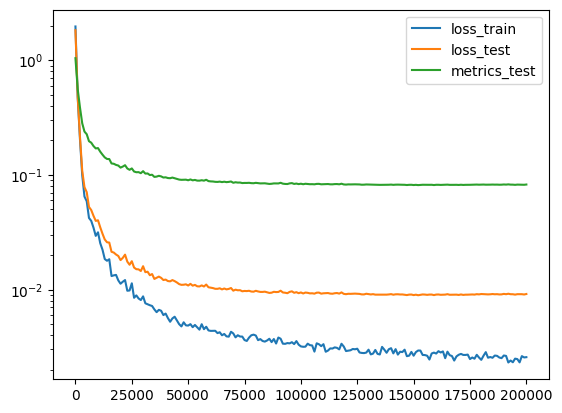

In [8]:
loss_data=losshistory.__dict__
fig=plt.figure()
ax=plt.subplot(1,1,1)
ax.plot(loss_data['steps'], loss_data['loss_train'],label='loss_train')
ax.plot(loss_data['steps'], loss_data['loss_test'],label='loss_test')
ax.plot(loss_data['steps'], loss_data['metrics_test'],label='metrics_test')
ax.legend()
ax.set_yscale('log')

In [9]:

error_s = []
for i in range(50):
    error_s_tmp = np.linalg.norm(y_test[i] - y_pred[i]) / np.linalg.norm(y_test[i])
    error_s.append(error_s_tmp)
error_s = np.stack(error_s)
print("error_s = ", error_s)



error_s =  [0.15632373 0.07865804 0.07532328 0.11978404 0.03941516 0.0585871
 0.14380053 0.06304095 0.1685772  0.05912    0.0283443  0.08879682
 0.09034123 0.10978089 0.06852875 0.09719663 0.12704122 0.08949094
 0.04895011 0.13731898 0.07496742 0.05398185 0.05468612 0.07741933
 0.05363689 0.07081605 0.06024227 0.05882575 0.05025183 0.09402595
 0.0655151  0.04169892 0.09854288 0.10006446 0.11109462 0.2162786
 0.03633209 0.09093957 0.04887288 0.10379981 0.03668924 0.08337175
 0.05588379 0.07368488 0.08127514 0.04860999 0.12259405 0.05093825
 0.10828192 0.04879629]


In [10]:

#### Plotting Results 

103
Index for minimum element: 10
Index for maximum element: 35
Index for median element: 0


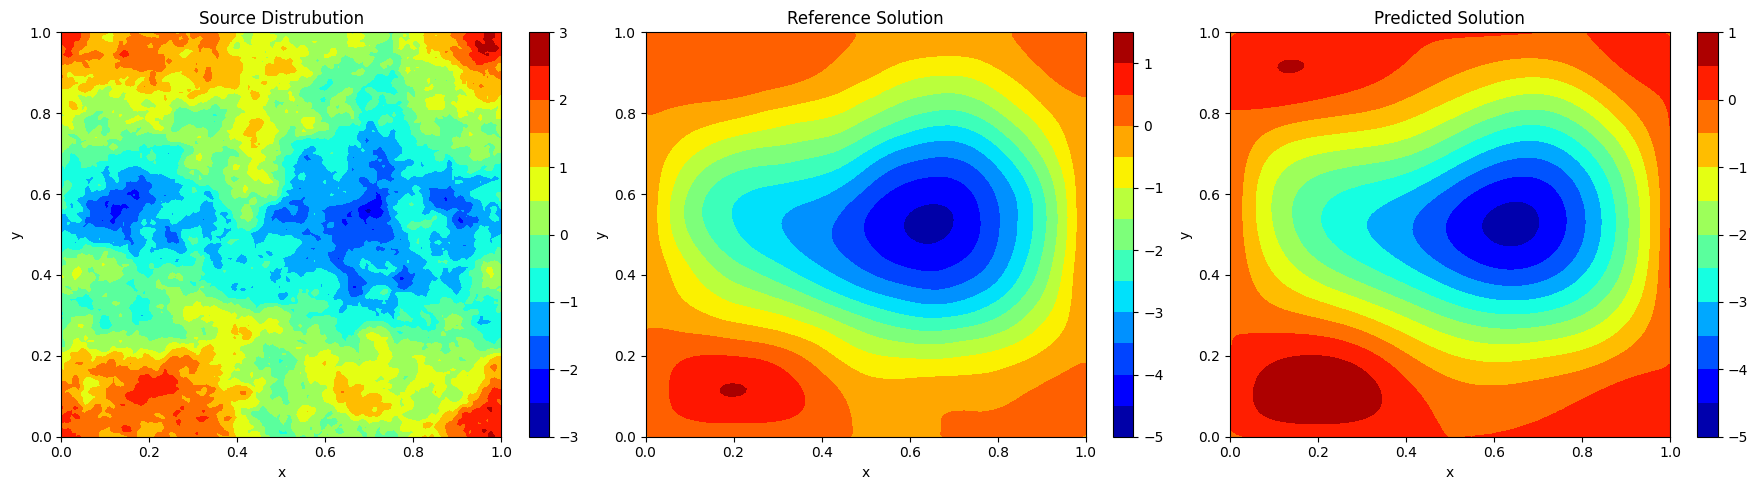

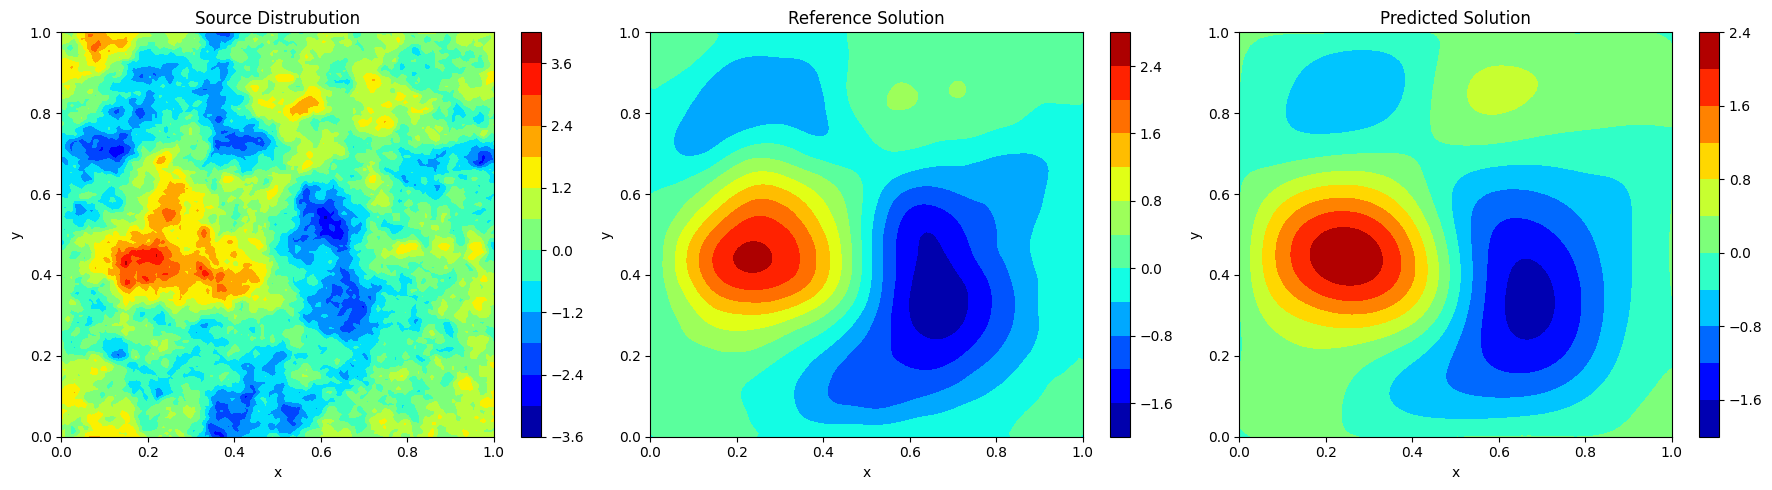

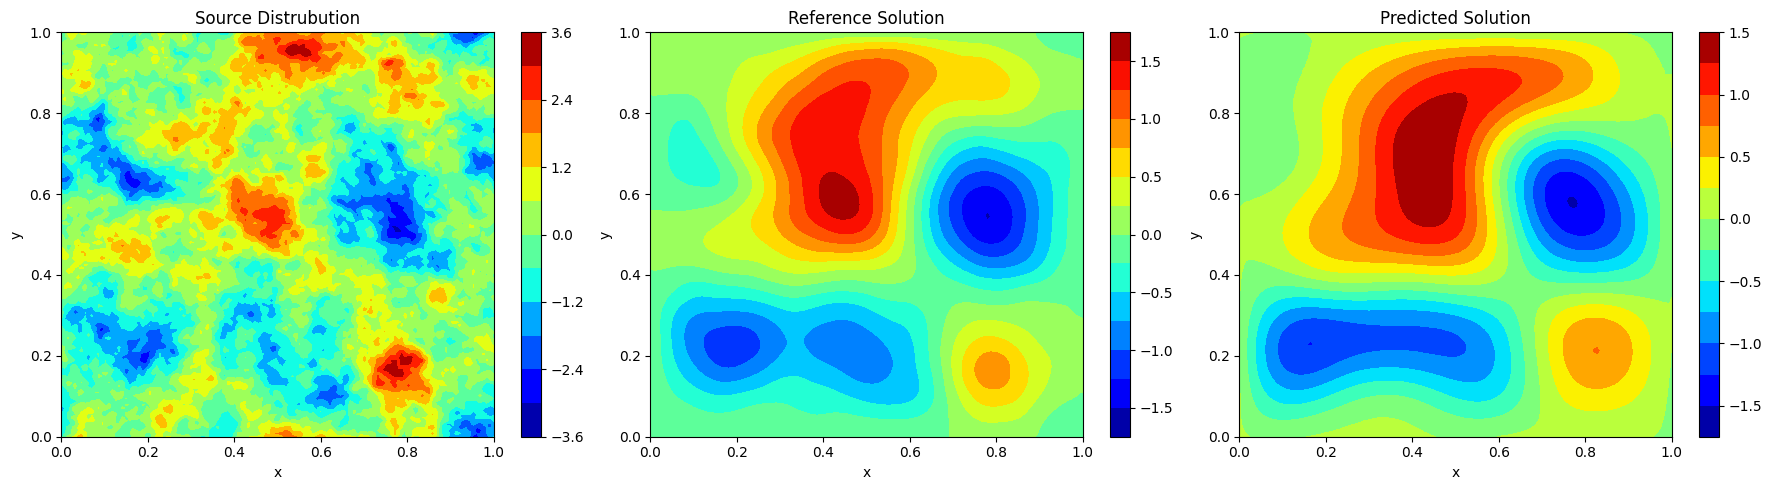

In [11]:
import matplotlib.pyplot as plt
import pylab as py
# Defining custom plotting functions
def my_contourf(x,y,F,ttl):
    cnt = py.contourf(x,y,F,12,cmap = 'jet')
    py.colorbar()
    py.xlabel('x'); py.ylabel('y'); py.title(ttl)
    return 0

rand_num = np.random.randint(Nx)
print(rand_num)
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)


min_index = np.argmin(error_s)
max_index = np.argmax(error_s)
median_index = np.median(error_s).astype(int)

# Print the indexes
print("Index for minimum element:", min_index)
print("Index for maximum element:", max_index)
print("Index for median element:", median_index)


min_median_max_index = np.array([min_index, median_index, max_index])


for index in min_median_max_index:

    u0_testing_nx_ny = u0_testing[index].reshape(Nx,Ny)
    s_testing_nx_ny = y_test[index].reshape(Nx,Ny)
    s_pred_nx_ny = y_pred[index].reshape(Nx,Ny)

    fig = plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    #py.figure(figsize = (14,7))
    my_contourf(x,y,u0_testing_nx_ny.T,r'Source Distrubution')
    plt.tight_layout()
    plt.subplot(1,3,2)
    #py.figure(figsize = (14,7))
    my_contourf(x,y,s_testing_nx_ny,r'Reference Solution')
    plt.tight_layout()
    plt.subplot(1,3,3)
    #py.figure(figsize = (14,7))
    my_contourf(x,y,s_pred_nx_ny,r'Predicted Solution')
    plt.tight_layout()
    # if index == min_index:
    #     plt.savefig("temperature_min_error_5000_3.jpg", dpi=300)
    # if index == median_index:
    #     plt.savefig("temperature_median_error_5000_3.jpg", dpi=300)
    # if index == max_index:
    #     plt.savefig("temperature_max_error_5000_3.jpg", dpi=300)
    #plt.savefig("temperature_sample{}_5000_3.jpg".format(index), dpi=300)
    plt.show()






In [12]:
def LaplaceOperator(x, y):
    dydx2 = dde.grad.hessian(y, x, i=0, j=0)
    dydy2 = dde.grad.hessian(y, x, i=1, j=1)
    return dydx2 + dydy2
class EvaluateDerivatives():
    """Generates the derivative of the outputs with respect to the trunck inputs.

    Args:
        model: DeepOnet.
        operator: Operator to apply to the outputs for derivative.
    """

    def __init__(self,model,operator):
        self.op=operator
        self.model=model
        @tf.function
        def op(inputs):
            y = self.model.net(inputs)
             # QB: inputs[1] is the input of the trunck
             # QB: y[0] is the output corresponding
             # to the first input sample of the branch input,
             # each time we only consider one sample
            return self.op(inputs[1], y[0][:,None]) 
        self.tf_op = op
    def eval(self,inputs):
        self.value=[]
        input_branch,input_trunck=inputs
        for inp in input_branch:
            x=(inp[None,:],input_trunck)
            self.value.append(utils.to_numpy(self.tf_op(x)))
        self.value=np.array(self.value)
    def get_values(self):
        return self.value

In [13]:
laplace_op=EvaluateDerivatives(model,LaplaceOperator)

In [16]:
laplace_op.eval((data.train_x[0][min_median_max_index],data.train_x[1]))
laplace_op_val=-0.01*laplace_op.get_values()

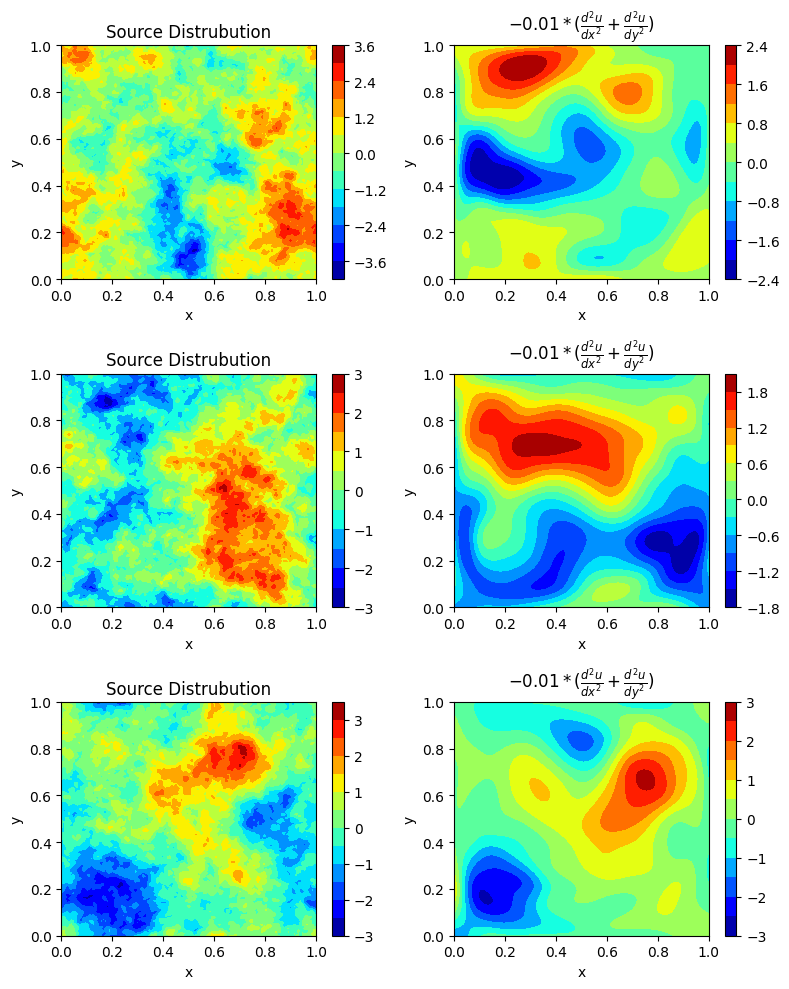

In [17]:
nr,nc=3,2
i=0
fig = plt.figure(figsize=(8,10))
ax=plt.subplot(nr,nc,2*i+1)
#ax.contourf(x,y,data.train_x[0][min_median_max_index][i].reshape(Nx,Ny),12,cmap = 'jet')
my_contourf(x,y,data.train_x[0][min_median_max_index[i]].reshape(Nx,Ny).T,r'Source Distrubution')
plt.tight_layout()
ax=plt.subplot(nr,nc,2*i+2)
#ax.contourf(x,y,laplace_op_val[i].reshape(Nx,Ny),12,cmap = 'jet')
my_contourf(x,y,laplace_op_val[i].reshape(Nx,Ny).T,r'$-0.01*(\frac{d^2u}{dx^2}+\frac{d^2u}{dy^2})$')
plt.tight_layout()
i=1
ax=plt.subplot(nr,nc,2*i+1)
#ax.contourf(x,y,data.train_x[0][min_median_max_index][i].reshape(Nx,Ny),12,cmap = 'jet')
my_contourf(x,y,data.train_x[0][min_median_max_index[i]].reshape(Nx,Ny).T,r'Source Distrubution')
plt.tight_layout()
ax=plt.subplot(nr,nc,2*i+2)
my_contourf(x,y,laplace_op_val[i].reshape(Nx,Ny).T,r'$-0.01*(\frac{d^2u}{dx^2}+\frac{d^2u}{dy^2})$')
plt.tight_layout()
i=2
ax=plt.subplot(nr,nc,2*i+1)
#ax.contourf(x,y,data.train_x[0][min_median_max_index][i].reshape(Nx,Ny),12,cmap = 'jet')
my_contourf(x,y,data.train_x[0][min_median_max_index[i]].reshape(Nx,Ny).T,r'Source Distrubution')
plt.tight_layout()
ax=plt.subplot(nr,nc,2*i+2)
#ax.contourf(x,y,laplace_op_val[i].reshape(Nx,Ny),12,cmap = 'jet')
my_contourf(x,y,laplace_op_val[i].reshape(Nx,Ny).T,r'$-0.01*(\frac{d^2u}{dx^2}+\frac{d^2u}{dy^2})$')
plt.tight_layout()